In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from glue.ligolw import ligolw
from glue.ligolw import lsctables

import lal, lalframe

import pycbc.psd
import pycbc.inject
from pycbc.types.timeseries import TimeSeries as TS
from pycbc.types.frequencyseries import FrequencySeries as FS
import pycbc.types
import pycbc.frame
from pycbc.filter import resample_to_delta_t
from pycbc.waveform.utils import taper_timeseries as taper 
from pycbc.detector import Detector
from pycbc.inject import InjectionSet
from pycbc.types import float64, float32
from pycbc.psd.estimate import interpolate as interpolate
import lalsimulation as ls
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/glue/ligolw/lsctables.py:48: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


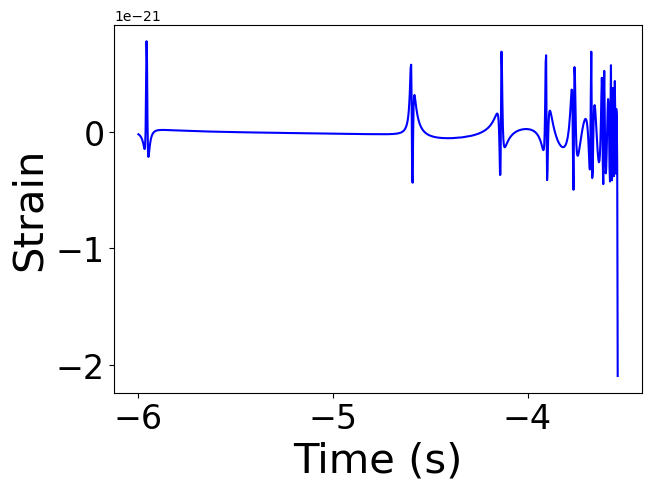

In [3]:
#h_eff = hp + 1j*hc
h_eff = np.loadtxt('waveform_simulation_trial233.dat')[:,1]
time_array = np.loadtxt('waveform_simulation_trial233.dat')[:,0]
id_tc = np.argmax(np.abs(h_eff))
#print(time_array/3.154e+7)
tc = time_array[id_tc] #Time of closest approach
time_x = np.linspace(-6, 6, len(time_array))
srate = 4096.
plt.figure(constrained_layout=True)
#Using waveform 0.5 seconds on either side of tc
left_duration = 0.5
right_duration = 0.5
signal_duration = right_duration + left_duration
id_left = int(id_tc - left_duration*srate)
id_right = int(id_tc +  right_duration*srate)
label_size = 24
#plt.xticks([-0.12, -0.06, 0.0, 0.06, 0.12])
plt.tick_params(labelsize=label_size)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(time_array - 6, h_eff, c='b') #time_array/3.154e+7
#plt.plot(time_x, h_eff, c='b')
#plt.plot(time_x, time_x*0, '--', c='g')
#plt.xlim([-5.99, 5.50])
#plt.ylim([-1.45e-19, 1.45e-19])
plt.ylabel("Strain", fontsize=30)
plt.xlabel("Time (s)", fontsize=30)
#plt.get_xaxis().set_visible(False)
plt.grid(False)
#plt.savefig("162_2_fontsize30.png", dpi = 600)


65537
32769


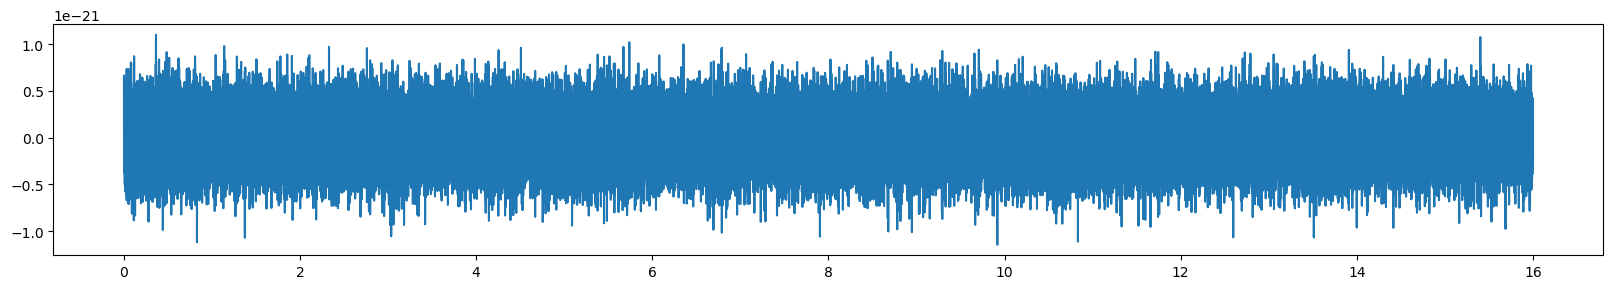

In [4]:
flow = 30.0
delta_f = 1.0 / 16
flen = int(4096 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

print(len(psd))
# Generate 16 seconds of noise at 4096 Hz
delta_t = 1/4096
tsamples = int(16 / delta_t)
strain = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
stilde = strain.to_frequencyseries()
print(len(stilde))
psd.resize(len(stilde))
plt.plot(strain.sample_times, strain)


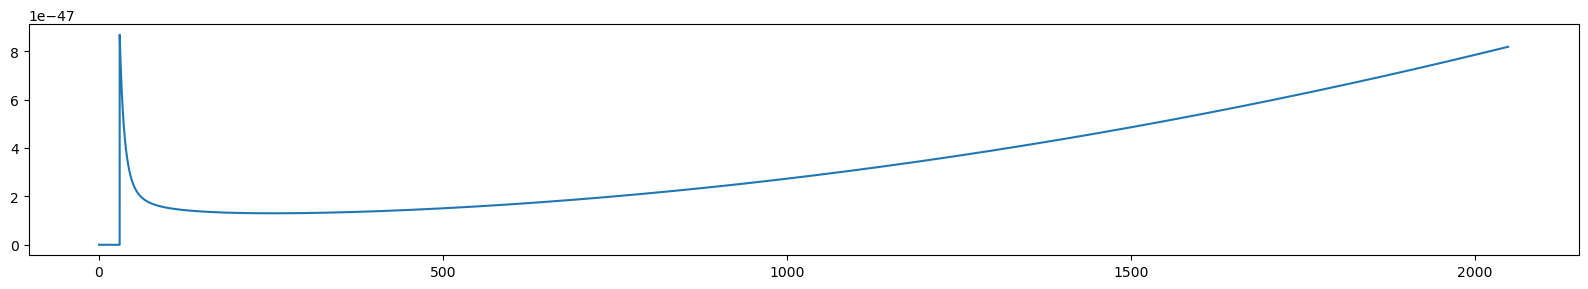

In [5]:
plt.plot(psd.sample_frequencies, psd)

(3.9, 4.2)

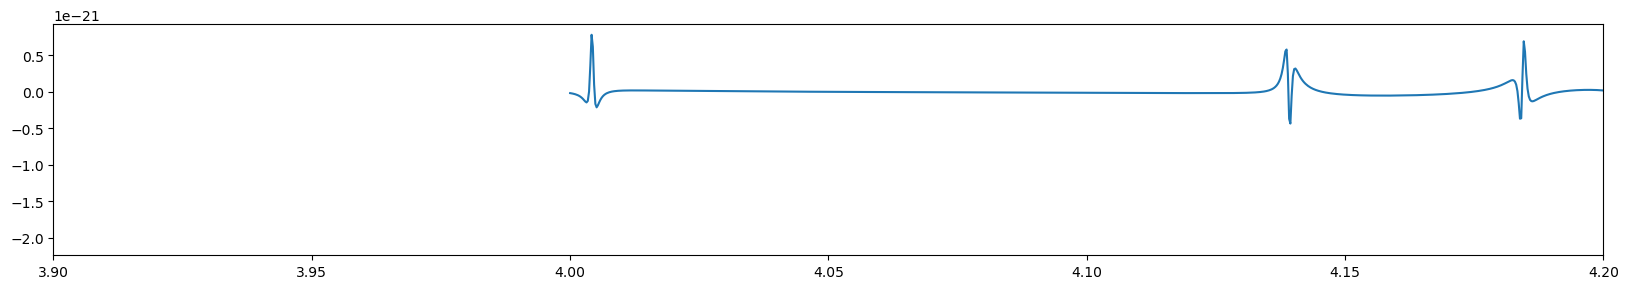

In [6]:
#h_eff *=10e5
h_eff_ts =  pycbc.types.TimeSeries(h_eff, delta_t=1/4096, epoch=4)
h_eff_ts.resize(len(stilde))
h_eff_fs = h_eff_ts.to_frequencyseries(delta_f=1.0 / 16)
plt.plot(h_eff_ts.sample_times, h_eff_ts)
plt.xlim(3.9, 4.2)

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


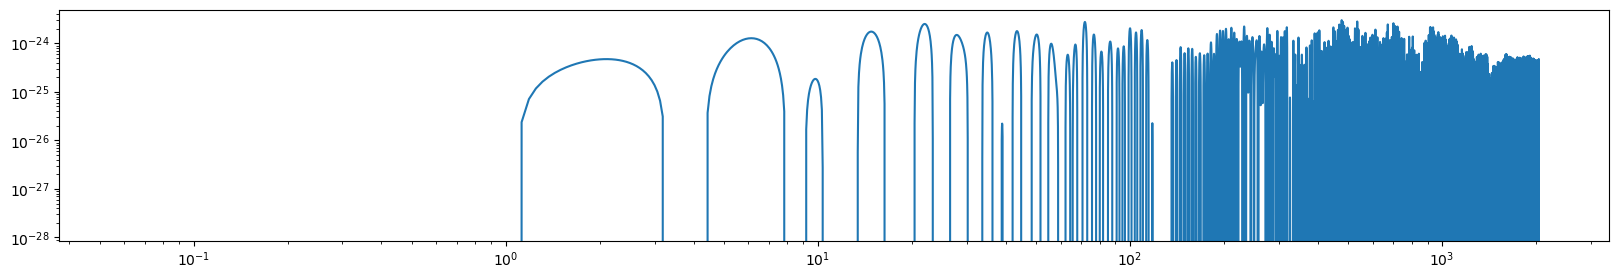

In [7]:
plt.plot(h_eff_fs.sample_frequencies, h_eff_fs)
plt.xscale('log')
plt.yscale('log')

In [8]:
snr = pycbc.filter.matched_filter(h_eff_fs, stilde) #, psd=psd)
                                      #low_frequency_cutoff=flow)

(3.9, 4.2)

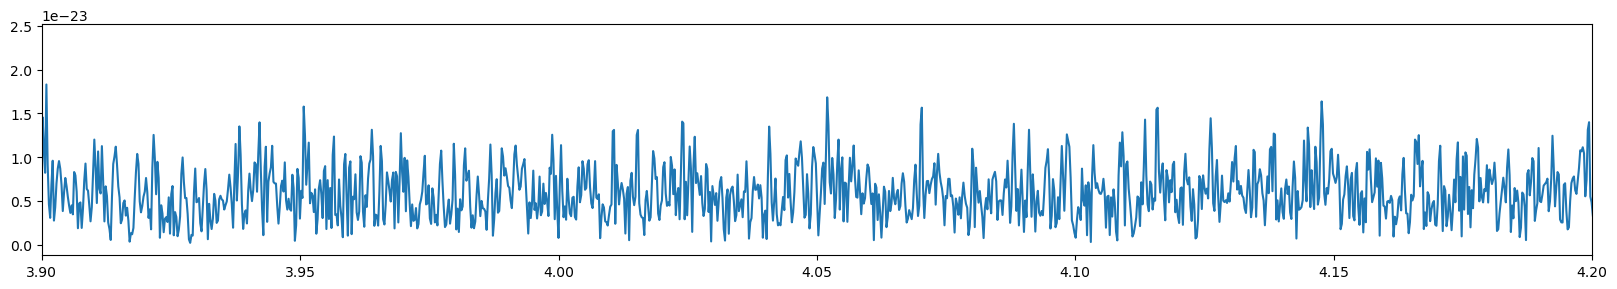

In [9]:
plt.plot(snr.sample_times, abs(snr))

plt.xlim(3.9, 4.2)

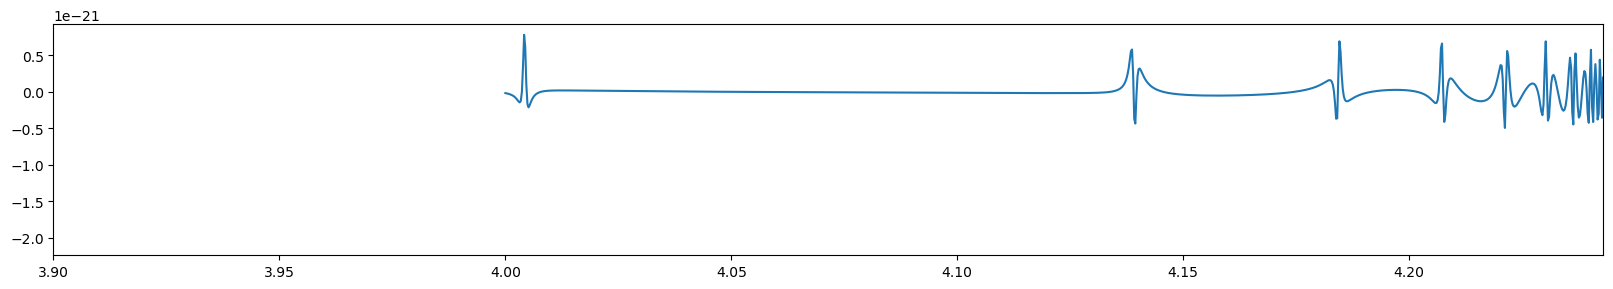

In [10]:
scale = 1
plt.plot(h_eff_ts.sample_times, h_eff_ts/scale)
plt.xlim(3.9, 4.243)
h_eff_ts /= scale

In [11]:
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return x, y

In [12]:
freq_psd_AD, strain_PSD_AD = Read_Two_Column_File('/home/tell.lott/Projects/hyp_BW/PSD/aLigo_PSD.dat')


[2.34436732e-40 2.33135930e-40 2.31835128e-40 ... 3.75301598e-44
 3.75313027e-44 3.75324455e-44]


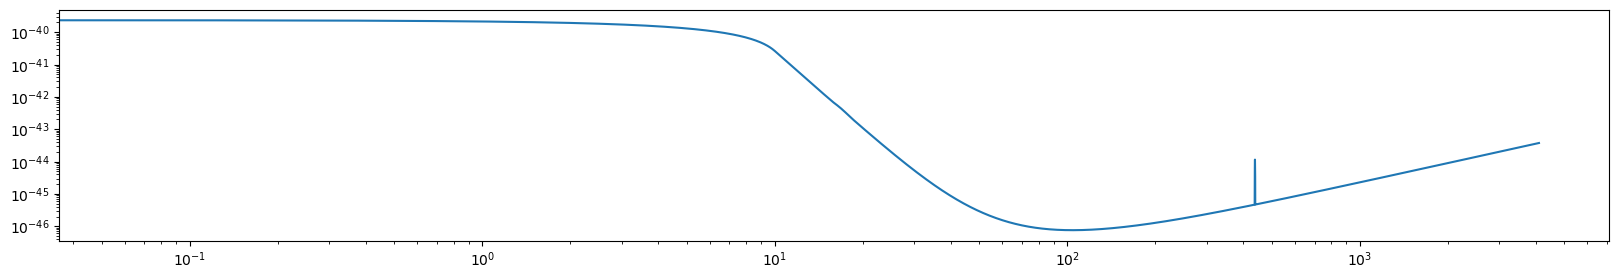

In [13]:
from scipy import interpolate

interp_func = interpolate.interp1d(freq_psd_AD, strain_PSD_AD, kind='linear', bounds_error=False, fill_value="extrapolate")
#interp_func = interpolate.interp1d(freq_psd, strain_PSD, kind='linear', bounds_error=False, fill_value=np.NaN)


x = np.arange(0, 4096, 0.0625) # 8169.5
f = interp_func(x)
strain_PSD_FS = pycbc.types.frequencyseries.FrequencySeries(f, delta_f=0.0625
)
print(strain_PSD_FS)
plt.xscale("log")
plt.yscale("log")
plt.plot(x, f)

In [14]:
psd_1 = strain_PSD_FS
psd_1.resize(len(stilde))


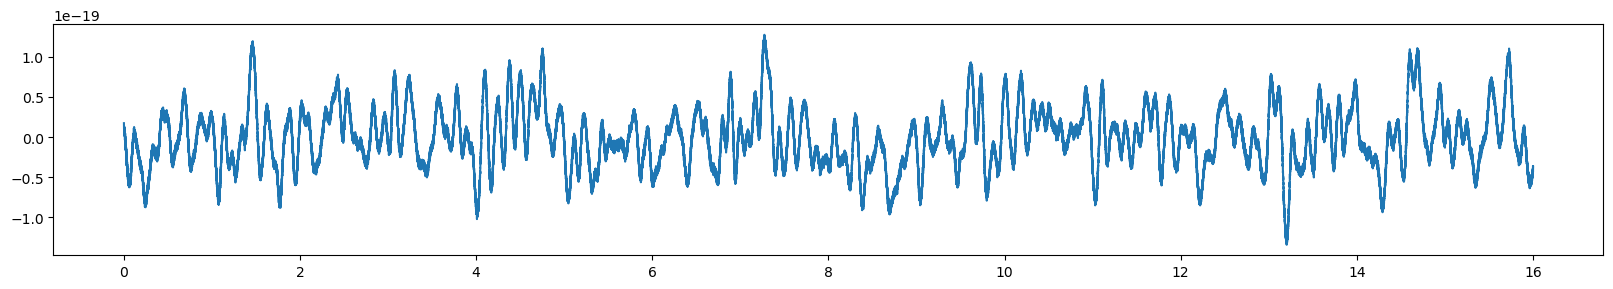

In [15]:
strain = pycbc.noise.noise_from_psd(tsamples, delta_t, psd_1, seed=127)
stilde = strain.to_frequencyseries()
plt.plot(strain.sample_times, strain)

In [16]:

snr1 = pycbc.filter.matched_filter(h_eff_fs, stilde/1e1, psd=psd_1,
                              low_frequency_cutoff=30)
#snr1 = snr1.crop(4 + 4, 4)

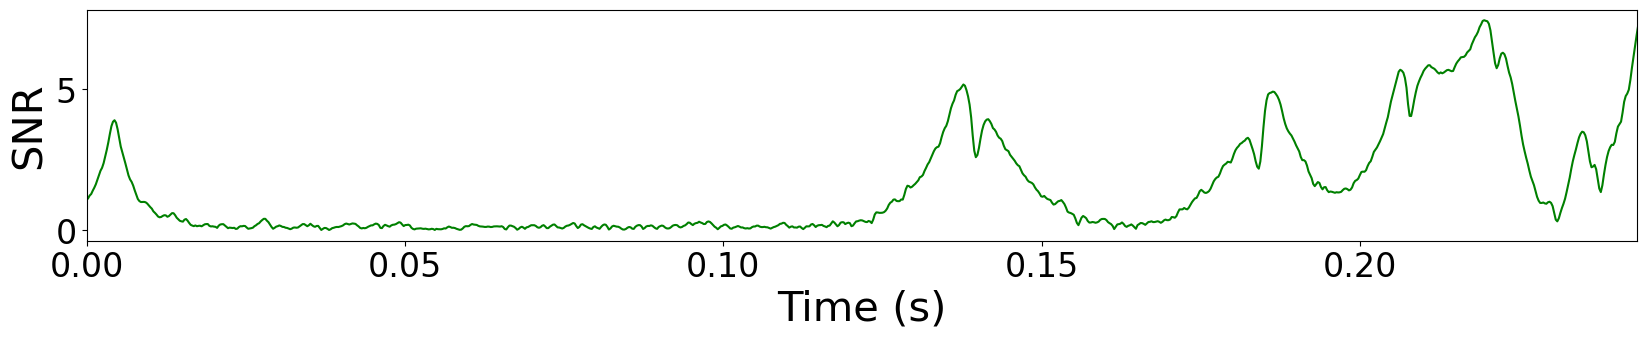

In [17]:
label_size = 24
#plt.xticks([-0.12, -0.06, 0.0, 0.06, 0.12])
plt.tick_params(labelsize=label_size)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(-1*snr1.sample_times + 16, abs(snr1), c='green')
plt.xlim(0.0, 0.2434)
#plt.clf
plt.ylabel("SNR", fontsize=30)
plt.xlabel("Time (s)", fontsize=30)
plt.savefig("SNR_233.png",  bbox_inches='tight', dpi=600)


#### plt.plot(stilde.sample_frequencies, stilde)


Text(0.5, 0, 'Time (s)')

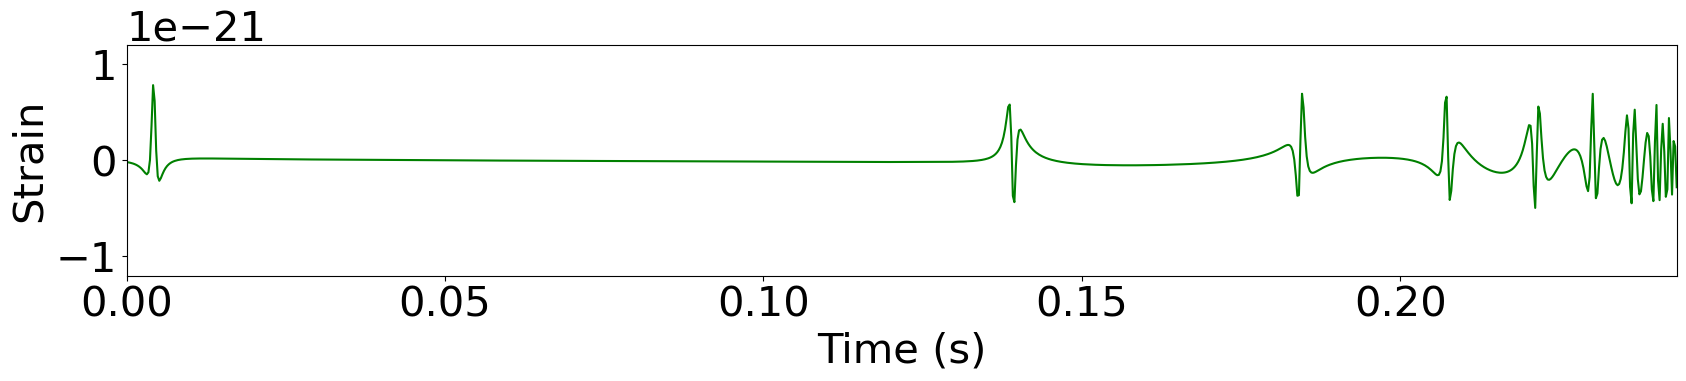

In [18]:
plt.rc('font', size=30)
plt.ylim(-1.2e-21, 1.2e-21)
plt.plot(h_eff_ts.sample_times -4, h_eff_ts/scale, c='green')
plt.xlim(0.0, 0.2434)
plt.ylabel("Strain")

plt.xlabel("Time (s)")

#plt.savefig("waveform_233.png",  bbox_inches='tight', dpi=600)


In [19]:
def plot_COM(ax, inner_x, inner_y, perturber_x, perturber_y, m1, m2):
    #c = 3e8
    #G = 6.67430e-11
    inner_Rg = G_AU*m1/(c_AU**2)
    perturber_Rg = G_AU*m2/(c_AU**2)

    x_COM = (inner_x*m1 + perturber_x*m2)/(m1 + m2)
    y_COM = (inner_y*m1 + perturber_y*m2)/(m1 + m2)
    inner_x -= x_COM
    inner_y -= y_COM
    perturber_x -= x_COM
    perturber_y -= y_COM

    inner_x /= (inner_Rg + perturber_Rg)
    inner_y /= (inner_Rg + perturber_Rg)
    perturber_x /= (inner_Rg + perturber_Rg)
    perturber_y /= (inner_Rg + perturber_Rg)

    ax.scatter(inner_x[0], inner_y[0], s=1000, c = 'k')
    ax.plot(inner_x, inner_y, c = 'k', label=r'$m_1$', linewidth=5.5)
    ax.scatter(perturber_x[0], perturber_y[0], s=1000, c='green')
    ax.plot(perturber_x, perturber_y, c = 'green', linestyle='dashed', linewidth=5.5, label=r'$m_2$')
    #plt.legend()
    
    #x, y = plot_circle(1)
    ax.scatter(0, 0, marker='*', s=1000, color='black', label='COM')
    #ax.plot(x, y, color='black', linestyle='dashed', label='Collision Radius')
    #ax.plot(x, -y, color='black', linestyle='dashed')

    ax.set(xlabel='x (Inner Rg)', ylabel='y (Inner Rg)', title='sBH Center of Mass Frame')
    #plt.set(xlabel='x (Inner Rg + Perturber Rg)', ylabel='y (Inner Rg + Perturber Rg)')

    return

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Index(['Unnamed: 0', 'Time (yr)', 'Inner x (AU)', 'Inner y (AU)',
       'Inner z (AU)', 'Inner vx (AU/yr)', 'Inner vy (AU/yr)',
       'Inner vz (AU/yr)', 'Perturber x (AU)', 'Perturber y (AU)',
       'Perturber z (AU)', 'Perturber vx (AU/yr)', 'Perturber vy (AU/yr)',
       'Perturber vz (AU/yr)'],
      dtype='object')
1224
975
975


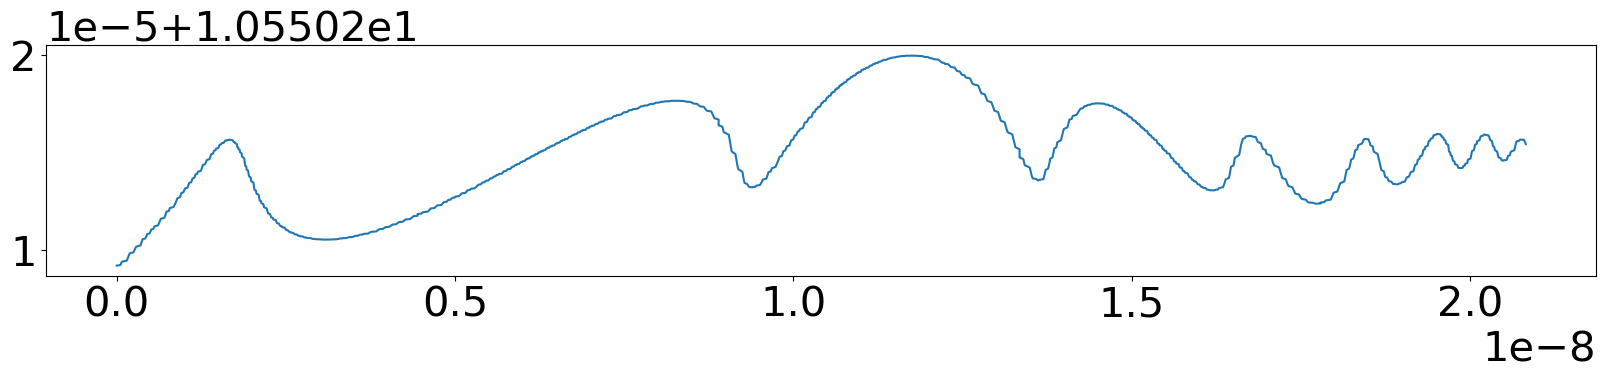

In [20]:
import pandas as pd
#trajectory_data = pd.read_csv("/home/tell.lott/Projects/rebound_jobs/export_data/run8164_event1/run8164_event1.csv", delimiter=',', header=0)
trajectory_data = pd.read_csv("1PN+2.5PN_1e6_233_3.csv", delimiter=',', header=0)

print(trajectory_data.columns)
#print(trajectory_data)
t = trajectory_data["Time (yr)"].values
print(len(t))
x_inner = trajectory_data["Inner x (AU)"].values
x_inner = [x for x in x_inner if ~np.isnan(x)]
x_inner = np.asarray(x_inner)

y_inner = trajectory_data["Inner y (AU)"].values
y_inner = [y for y in y_inner if ~np.isnan(y)]
y_inner = np.asarray(y_inner)

z_inner = trajectory_data["Inner z (AU)"].values
z_inner = [z for z in z_inner if ~np.isnan(z)]
z_inner = np.asarray(z_inner)

r_inner = np.sqrt(x_inner ** 2 + y_inner ** 2 + z_inner **2)
print(len(r_inner))
t = t[0:len(r_inner)]
print(len(t))

plt.plot(t, r_inner)

975
975
975
975


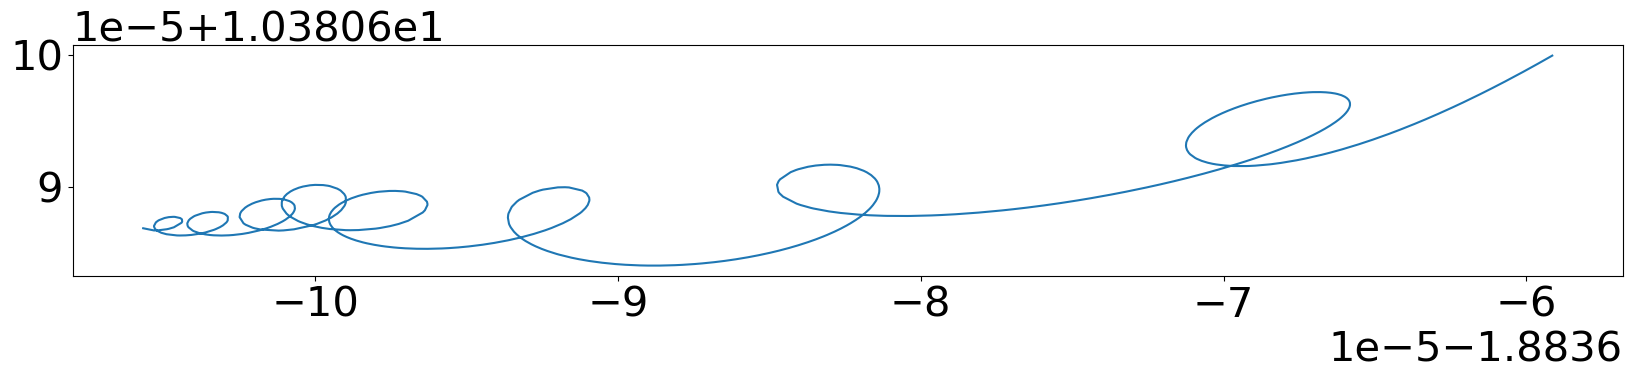

In [21]:
x_perturb = trajectory_data["Perturber x (AU)"].values
x_perturb = [x for x in x_perturb if ~np.isnan(x)]
x_perturb = np.asarray(x_perturb)
print(len(x_perturb))
y_perturb = trajectory_data["Perturber y (AU)"].values
y_perturb = [y for y in y_perturb if ~np.isnan(y)]
y_perturb = np.asarray(y_perturb)
print(len(y_perturb))
z_perturb = trajectory_data["Perturber z (AU)"].values
z_perturb = [z for z in z_perturb if ~np.isnan(z)]
z_perturb = np.asarray(z_perturb)
print(len(z_perturb))

r_perturb = np.sqrt(x_perturb ** 2 + y_perturb ** 2 + z_perturb **2)
print(len(r_perturb))

plt.close("close")
#plt.plot(t, r_perturb)
plt.plot(x_perturb, y_perturb)

Bbox(x0=0.125, y0=0.24022058823529413, x1=0.9, y1=0.32514705882352946)
Bbox(x0=0.125, y0=0.10999999999999999, x1=0.9, y1=0.1949264705882353)


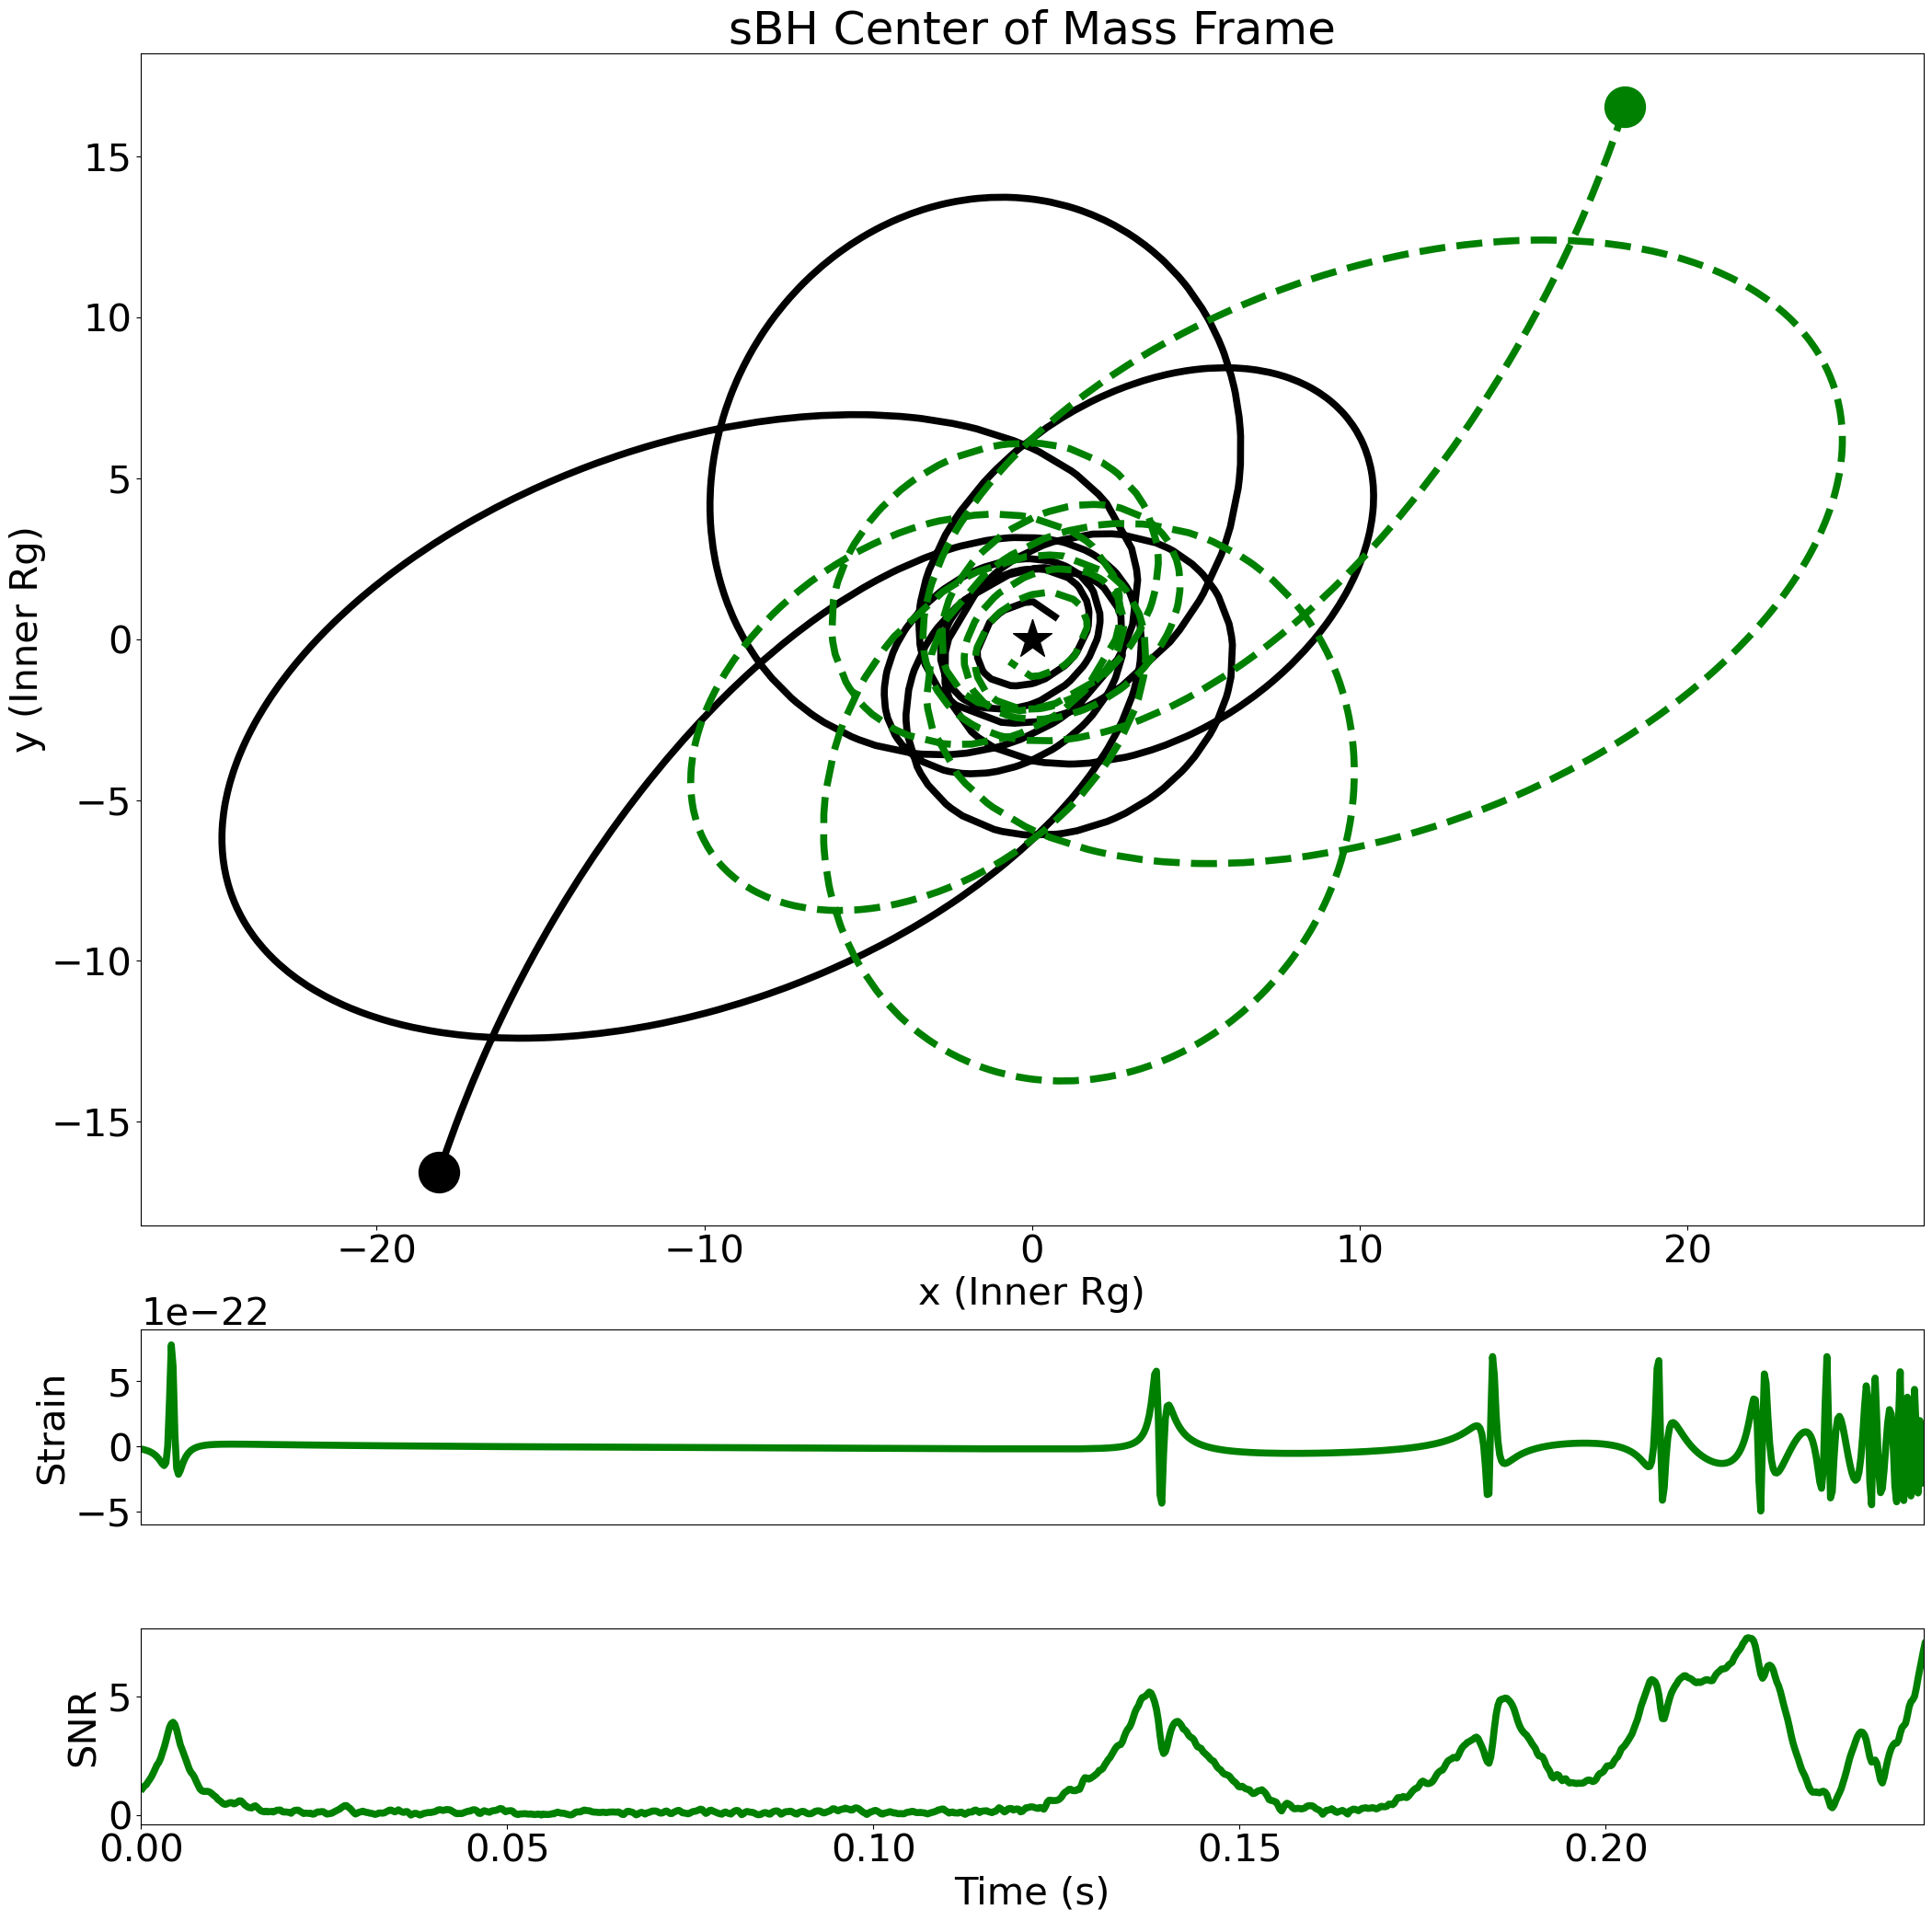

In [22]:
G_AU = 39.478
c_AU = 63284.9
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(25, 25), gridspec_kw={'height_ratios': [9, 1.5, 1.5]})
plot_COM(ax, x_inner, y_inner, x_perturb, y_perturb, 20, 20)

plt.rc('font', size=25)
plt.rc('legend', fontsize=25)
plt.rc('axes', titlesize=25)
ax1.set_ylim(-0.6e-21, 0.9e-21)
ax1.plot(h_eff_ts.sample_times - 4., h_eff_ts/scale, c='green', linewidth=5.5)
ax1.set_xlim(0.0, 0.2434)

ax1.set_ylabel("Strain", fontsize=30)
ax1.axes.xaxis.set_visible(False)
ax2.plot(-1*snr1.sample_times + 16, abs(snr1), c='green', linewidth=5.5)
#ax1.set_xlim(0.0, 0.2434)
ax2.set_xlim(0.0, 0.2434)
pos1 = ax1.get_position()
print(pos1)
#pos1.y0 += -0.04
ax1.set_position(pos1)

pos2 = ax2.get_position()
print(pos2)
#pos2.y0 += -0.04
ax2.set_position(pos2)

#plt.clf
ax2.set_ylabel("SNR", fontsize=30)
ax2.set_xlabel("Time (s)", fontsize=30)
#plt.tight_layout()
fig.savefig("trajec_SNR_233_LARGE.png", bbox_inches='tight', dpi=300)

[-1.8774e-23 -2.1692e-23 -2.5092e-23 ...  0.0000e+00  0.0000e+00
  0.0000e+00]


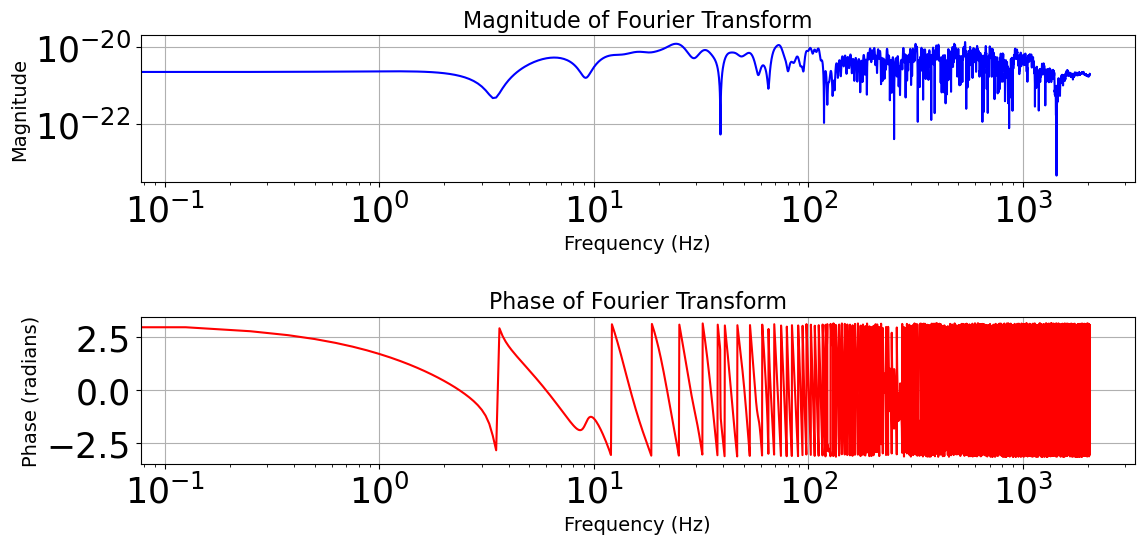

In [23]:
# Sample data (replace with your actual data)
strain =  h_eff_ts.data

print(strain)
#strain = np.random.randn(4096)  # Example strain data, replace with your actual strain data
delta_t = 1/4096  # Sampling interval, replace with your actual value

# Compute the Fourier transform
strain_fft = np.fft.fft(strain)
# Compute the frequencies corresponding to the FFT
n = len(strain)
frequencies = np.fft.fftfreq(n, d=delta_t)

# Only keep the positive frequencies for plotting
positive_frequencies = frequencies[:n // 2]
positive_fft = strain_fft[:n // 2]

# Plot the magnitude and phase of the Fourier transform
plt.figure(figsize=(12, 6))

# Plot magnitude
plt.subplot(2, 1, 1)
plt.plot(positive_frequencies, np.abs(positive_fft), color='b')
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.title("Magnitude of Fourier Transform", fontsize=16)
plt.grid(True)
plt.xscale('log')  # Optional: use log scale for better visualization
plt.yscale('log')  # Optional: use log scale for better visualization

# Plot phase
plt.subplot(2, 1, 2)
plt.plot(positive_frequencies, np.angle(positive_fft), color='r')
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.ylabel("Phase (radians)", fontsize=14)
plt.title("Phase of Fourier Transform", fontsize=16)
plt.grid(True)
plt.xscale('log')  # Optional: use log scale for better visualization

plt.tight_layout()
plt.show()